In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf

# %matplotlib notebook

rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

In [ ]:
%matplotlib inline

importlib.reload(jm)
# fileHandle = 'ShearJefferyProblem'
# job_dir = 'head_shear_velocity1a'
# job_name = 'eq_a00.10_z-1.00'
# talpha = 1 / 0.1
# tcenter = np.array((0, 0, -1))
# ellipse_velocity = 1
# tnorm = np.array((1, 0, 0))
# lateral_norm = np.array((1, 0, 0))
# planeShearRate = (2, 0, 0)

fileHandle = 'ShearJefferyProblem'
job_dir = 'head_shear2'
job_name = 'eq_theta3.045_phi2.105'
talpha = 3
ellipse_velocity = 0
planeShearRate = (1, 0, 0)

mat_path = os.path.join(PWD, job_dir, job_name)
mat_contents = loadmat(mat_path)
ecoli_center = mat_contents['ecoli_center']
ecoli_norm = mat_contents['ecoli_norm']
ecoli_U = mat_contents['ecoli_U']
eval_t = mat_contents['t'].flatten()
ecoli_t = eval_t
eval_dt = np.mean(np.diff(eval_t))
max_iter = eval_t.size * 2
problem = jm.ShearJefferyProblem(planeShearRate=planeShearRate)
tnorm = ecoli_norm[0]
tcenter = ecoli_center[0]
lateral_norm = np.array((1, 0, 0))
lateral_norm = lateral_norm - tnorm / np.linalg.norm(tnorm) * np.dot(tnorm, lateral_norm) / np.linalg.norm(lateral_norm)
lateral_norm = lateral_norm / np.linalg.norm(lateral_norm)

ellipse_kwargs = {'name':     job_name,
                  'center':   tcenter,
                  'norm':     tnorm / np.linalg.norm(tnorm),
                  'lateral_norm':  lateral_norm / np.linalg.norm(lateral_norm),
                  'speed': ellipse_velocity,
                  'lbd':      (talpha ** 2 - 1) / (talpha ** 2 + 1)}
ellipse_obj = jm.JefferyObj(**ellipse_kwargs)
# ellipse_obj.dbg_set_update_para(fix_x=0, fix_y=0, fix_z=0)
problem.add_obj(ellipse_obj)

# evaluation loop
t0 = time()
for idx in range(1, max_iter + 1):
    problem.update_location(eval_dt, print_handle='%d / %d' % (idx, max_iter))
t1 = time()
print('%s: run %d loops using %f' % (fileHandle, max_iter, (t1 - t0)))
jeffery_t = np.arange(max_iter) * eval_dt + eval_dt
center_hist = np.vstack(ellipse_obj.center_hist)
U_hist = np.vstack(ellipse_obj.U_hist)
norm_hist = np.vstack(ellipse_obj.norm_hist)

t_stp = ecoli_center.shape[0] // 100
fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5)] = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0.plot(jeffery_t, center_hist[:, 0], '-*', label='Jeffery')
ax1.plot(jeffery_t, center_hist[:, 1], '-*', label='Jeffery')
ax2.plot(jeffery_t, center_hist[:, 2], '-*', label='Jeffery')
ax0.plot(ecoli_t, ecoli_center[:, 0], '-*', label='Sim')
ax1.plot(ecoli_t, ecoli_center[:, 1], '-*', label='Sim')
ax2.plot(ecoli_t, ecoli_center[:, 2], '-*', label='Sim')
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('center_%s' % axyi, size=fontsize)
    axi.legend(fontsize=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()
ax3.plot(jeffery_t, norm_hist[:, 0], '-*', label='Jeffery')
ax4.plot(jeffery_t, norm_hist[:, 1], '-*', label='Jeffery')
ax5.plot(jeffery_t, norm_hist[:, 2], '-*', label='Jeffery')
ax3.plot(ecoli_t, ecoli_norm[:, 0], '-*', label='Sim')
ax4.plot(ecoli_t, ecoli_norm[:, 1], '-*', label='Sim')
ax5.plot(ecoli_t, ecoli_norm[:, 2], '-*', label='Sim')
for axi, axyi in zip((ax3, ax4, ax5, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('ecoli_norm_%s' % axyi, size=fontsize)
    axi.legend(fontsize=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5), (ax6, ax7)] = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0.plot(jeffery_t, U_hist[:, 0], '-*', label='Jeffery')
ax1.plot(jeffery_t, U_hist[:, 1], '-*', label='Jeffery')
ax2.plot(jeffery_t, U_hist[:, 2], '-*', label='Jeffery')
ax3.plot(jeffery_t, U_hist[:, 3], '-*', label='Jeffery')
ax4.plot(jeffery_t, U_hist[:, 4], '-*', label='Jeffery')
ax5.plot(jeffery_t, U_hist[:, 5], '-*', label='Jeffery')
ax0.plot(ecoli_t, ecoli_U[:, 0], '-*', label='Sim')
ax1.plot(ecoli_t, ecoli_U[:, 1], '-*', label='Sim')
ax2.plot(ecoli_t, ecoli_U[:, 2], '-*', label='Sim')
ax3.plot(ecoli_t, ecoli_U[:, 3], '-*', label='Sim')
ax4.plot(ecoli_t, ecoli_U[:, 4], '-*', label='Sim')
ax5.plot(ecoli_t, ecoli_U[:, 5], '-*', label='Sim')
ax6.plot(jeffery_t, np.linalg.norm(U_hist[:, :3], axis=1), '-*', label='Jeffery')
ax7.plot(jeffery_t, np.linalg.norm(U_hist[:, 3:], axis=1), '-*', label='Jeffery')
ax6.plot(ecoli_t, np.linalg.norm(ecoli_U[:, :3], axis=1), '-*', label='Sim')
ax7.plot(ecoli_t, np.linalg.norm(ecoli_U[:, 3:], axis=1), '-*', label='Sim')
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('ecoli_u_%s' % axyi, size=fontsize)
    axi.legend(fontsize=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
for axi, axyi in zip((ax3, ax4, ax5, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('ecoli_w_%s' % axyi, size=fontsize)
    axi.legend(fontsize=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
for axi, axyi in zip((ax6, ax7), ('|ecoli_U|', '|ecoli_W|')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel(axyi, size=fontsize)
    axi.legend(fontsize=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1, projection='3d')
cax1 = inset_axes(ax0, width="100%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=1, bbox_transform=ax0.transAxes, borderpad=0,)
norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
cmap=plt.get_cmap('jet')
# Create the 3D-line collection object
points = ecoli_center.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = Line3DCollection(segments, cmap=cmap, norm=norm)
lc.set_array(ecoli_t) 
ax0.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
ax0.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
ax0.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
ax0.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
clb = fig.colorbar(lc, cax=cax1, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Sim, time', size=fontsize)
spf.set_axes_equal(ax0)
ax0.plot(np.ones_like(ecoli_center[:, 0])*ax0.get_xlim()[0], ecoli_center[:, 1], ecoli_center[:, 2])
ax0.plot(ecoli_center[:, 0], np.ones_like(ecoli_center[:, 1])*ax0.get_ylim()[1], ecoli_center[:, 2])
ax0.plot(ecoli_center[:, 0], ecoli_center[:, 1], np.ones_like(ecoli_center[:, 0])*ax0.get_zlim()[0])
color_len = ecoli_center[::t_stp, 0].size
quiver_length = np.max(ecoli_center.max(axis=0) - ecoli_center.min(axis=0)) * 0.05
colors = [cmap(1.*i/color_len) for i in range(color_len)]
ax0.quiver(ecoli_center[::t_stp, 0], ecoli_center[::t_stp, 1], ecoli_center[::t_stp, 2], 
           ecoli_norm[::t_stp, 0], ecoli_norm[::t_stp, 1], ecoli_norm[::t_stp, 2], 
           length=quiver_length, arrow_length_ratio=0.2, pivot='middle', normalize=False, colors=colors)
plt.sca(ax0)
ax0.set_xlabel('X', size=fontsize)
ax0.set_ylabel('Y', size=fontsize)
ax0.set_zlabel('Z', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
for t in ax0.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize*0.8)
for spine in ax0.spines.values():
    spine.set_visible(False)
plt.tight_layout()


# fig = plt.figure(figsize=(60, 20))
# fig.patch.set_facecolor('white')
# axs = fig.subplots(1, 3)
# for axi, (txi, tyi), (xlabel, ylabel) in zip(axs, 
#                                              ((0, 1), (1, 2), (2, 0)), 
#                                              (('X', 'Y'), ('Y', 'Z'), ('Z', 'X'))):
#     caxi = inset_axes(axi, width="100%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
#                       loc=1, bbox_transform=axi.transAxes, borderpad=0,)
#     norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
#     cmap=plt.get_cmap('jet')
#     lc = spf.colorline(ecoli_center[:, txi], ecoli_center[:, tyi], ecoli_t, ax=axi, cmap=cmap, norm=norm, linewidth=3)
#     clb = fig.colorbar(lc, cax=caxi, orientation="horizontal")
#     clb.ax.tick_params(labelsize=fontsize)
#     clb.ax.set_title('Sim, time', size=fontsize)
#     axi.set_xlim((ecoli_center[:, txi].min(), ecoli_center[:, txi].max()))
#     axi.set_ylim((ecoli_center[:, tyi].min(), ecoli_center[:, tyi].max()))
    
#     color_len = ecoli_center[::t_stp, 0].size
#     colors = [cmap(1.*i/color_len) for i in range(color_len)]
#     t_norm = np.sqrt(ecoli_norm[:, txi]**2 + ecoli_norm[:, tyi]**2)
#     axi.quiver(ecoli_center[::t_stp, txi], ecoli_center[::t_stp, tyi], 
#                ecoli_norm[::t_stp, txi] / t_norm[::t_stp], ecoli_norm[::t_stp, tyi] / t_norm[::t_stp], 
#                color=colors, pivot='middle')
#     plt.sca(axi)
#     axi.set_xlabel(xlabel, size=fontsize)
#     axi.set_ylabel(ylabel, size=fontsize)
#     plt.xticks(fontsize=fontsize*0.8)
#     plt.yticks(fontsize=fontsize*0.8)
#     spf.set_axes_equal(axi)
# plt.tight_layout()

fig = plt.figure(figsize=(40, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
# U
ax0.set_title('ecoli_U', size=fontsize)
cax0 = inset_axes(ax0, width="80%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=1, bbox_transform=ax0.transAxes, borderpad=0,)
norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
cmap=plt.get_cmap('jet')
# Create the 3D-line collection object
points = ecoli_U[:, :3].reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = Line3DCollection(segments, cmap=cmap, norm=norm)
lc.set_array(ecoli_t) 
ax0.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
ax0.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
ax0.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
ax0.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
spf.set_axes_equal(ax0)
ax0.plot(np.ones_like(points[:, :, 0].flatten())*ax0.get_xlim()[0], points[:, :, 1].flatten(), points[:, :, 2].flatten())
ax0.plot(points[:, :, 0].flatten(), np.ones_like(points[:, :, 1].flatten())*ax0.get_ylim()[1], points[:, :, 2].flatten())
ax0.plot(points[:, :, 0].flatten(), points[:, :, 1].flatten(), np.ones_like(points[:, :, 2].flatten())*ax0.get_zlim()[0])
clb = fig.colorbar(lc, cax=cax0, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Sim, time', size=fontsize)
plt.sca(ax0)
ax0.set_xlabel('ux', size=fontsize)
ax0.set_ylabel('uy', size=fontsize)
ax0.set_zlabel('uz', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
for t in ax0.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize*0.8)
for spine in ax0.spines.values():
    spine.set_visible(False)
# plt.tight_layout()

# W
ax1.set_title('ecoli_W', size=fontsize)
cax1 = inset_axes(ax1, width="80%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=1, bbox_transform=ax1.transAxes, borderpad=0,)
norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
cmap=plt.get_cmap('jet')
# Create the 3D-line collection object
points = ecoli_U[:, 3:].reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = Line3DCollection(segments, cmap=cmap, norm=norm)
lc.set_array(ecoli_t) 
ax1.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
ax1.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
ax1.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
ax1.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
spf.set_axes_equal(ax1)
ax1.plot(np.ones_like(points[:, :, 0].flatten())*ax1.get_xlim()[0], points[:, :, 1].flatten(), points[:, :, 2].flatten())
ax1.plot(points[:, :, 0].flatten(), np.ones_like(points[:, :, 1].flatten())*ax1.get_ylim()[1], points[:, :, 2].flatten())
ax1.plot(points[:, :, 0].flatten(), points[:, :, 1].flatten(), np.ones_like(points[:, :, 2].flatten())*ax1.get_zlim()[0])
clb = fig.colorbar(lc, cax=cax1, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Sim, time', size=fontsize)
plt.sca(ax1)
ax1.set_xlabel('wx', size=fontsize)
ax1.set_ylabel('wy', size=fontsize)
ax1.set_zlabel('wz', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
for t in ax1.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize*0.8)
for spine in ax1.spines.values():
    spine.set_visible(False)
plt.tight_layout()

fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1, projection='3d')
ax0.set_title('ecoli_norm', size=fontsize)
cax0 = inset_axes(ax0, width="80%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=1, bbox_transform=ax0.transAxes, borderpad=0,)
norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
cmap=plt.get_cmap('jet')
# Create the 3D-line collection object
points = ecoli_norm.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = Line3DCollection(segments, cmap=cmap, norm=norm)
lc.set_array(ecoli_t) 
ax0.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
ax0.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
ax0.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
ax0.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
spf.set_axes_equal(ax0)
ax0.plot(np.ones_like(points[:, :, 0].flatten())*ax0.get_xlim()[0], points[:, :, 1].flatten(), points[:, :, 2].flatten())
ax0.plot(points[:, :, 0].flatten(), np.ones_like(points[:, :, 1].flatten())*ax0.get_ylim()[1], points[:, :, 2].flatten())
ax0.plot(points[:, :, 0].flatten(), points[:, :, 1].flatten(), np.ones_like(points[:, :, 2].flatten())*ax0.get_zlim()[0])
clb = fig.colorbar(lc, cax=cax0, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Sim, time', size=fontsize)
plt.sca(ax0)
ax0.set_xlabel('px', size=fontsize)
ax0.set_ylabel('py', size=fontsize)
ax0.set_zlabel('pz', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
for t in ax0.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize*0.8)
for spine in ax0.spines.values():
    spine.set_visible(False)
plt.tight_layout()


In [ ]:
%matplotlib inline

importlib.reload(jm)
fileHandle = 'ShearJefferyProblem'
job_dir = 'head_shear_velocity1a'
job_name = 'eq_a00.10_z-1.00'
talpha = 1 / 0.1
tcenter = np.array((0, 0, -1))
ellipse_velocity = 1
tnorm = np.array((1, 0, 0))
lateral_norm = np.array((1, 0, 0))
lateral_norm = lateral_norm - tnorm / np.linalg.norm(tnorm) * np.dot(tnorm, lateral_norm) / np.linalg.norm(lateral_norm)
lateral_norm = lateral_norm / np.linalg.norm(lateral_norm)
planeShearRate = (2, 0, 0)

mat_path = os.path.join(PWD, job_dir, job_name)
mat_contents = loadmat(mat_path)
ecoli_center = mat_contents['ecoli_center']
ecoli_norm = mat_contents['ecoli_norm']
ecoli_U = mat_contents['ecoli_U']
eval_t = mat_contents['t'].flatten()
eval_dt = np.mean(np.diff(eval_t))
max_iter = eval_t.size * 2
problem = jm.ShearJefferyProblem(planeShearRate=planeShearRate)

ellipse_kwargs = {'name':     job_name,
                  'center':   tcenter,
                  'norm':     tnorm / np.linalg.norm(tnorm),
                  'lateral_norm':  lateral_norm / np.linalg.norm(lateral_norm),
                  'speed': ellipse_velocity,
                  'lbd':      (talpha ** 2 - 1) / (talpha ** 2 + 1)}
ellipse_obj = jm.JefferyObj(**ellipse_kwargs)
# ellipse_obj.dbg_set_update_para(fix_x=0, fix_y=0, fix_z=0)
problem.add_obj(ellipse_obj)

# evaluation loop
t0 = time()
for idx in range(1, max_iter + 1):
    problem.update_location(eval_dt, print_handle='%d / %d' % (idx, max_iter))
t1 = time()
print('%s: run %d loops using %f' % (fileHandle, max_iter, (t1 - t0)))

fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(3, 1, 1)
ax1 = fig.add_subplot(3, 1, 2)
ax2 = fig.add_subplot(3, 1, 3)
t0 = np.arange(max_iter) * eval_dt + eval_dt
center_hist = np.vstack(ellipse_obj.center_hist)
U_hist = np.vstack(ellipse_obj.U_hist)
norm_hist = np.vstack(ellipse_obj.norm_hist)
ax0.plot(t0, norm_hist[:, 0], label='Jeffery')
ax1.plot(t0, norm_hist[:, 1], label='Jeffery')
ax2.plot(t0, norm_hist[:, 2], label='Jeffery')
ax0.plot(eval_t, ecoli_norm[:, 0], label='Sim')
ax1.plot(eval_t, ecoli_norm[:, 1], label='Sim')
ax2.plot(eval_t, ecoli_norm[:, 2], label='Sim')
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('p_%s' % axyi, size=fontsize)
    axi.legend(fontsize=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)
cax1 = inset_axes(ax0, width="45%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=1, bbox_transform=ax0.transAxes, borderpad=0,)
cax2 = inset_axes(ax0, width="45%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=2, bbox_transform=ax0.transAxes, borderpad=0,)
norm=plt.Normalize(eval_t.min(), eval_t.max())
cmap=plt.get_cmap('Oranges')
lc = spf.colorline(ecoli_center[:, 0], ecoli_center[:, 2], eval_t, ax=ax0, cmap=cmap, norm=norm, linewidth=3)
clb = fig.colorbar(lc, cax=cax1, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Sim, time', size=fontsize)
norm=plt.Normalize(t0.min(), t0.max())
cmap=plt.get_cmap('Purples')
lc = spf.colorline(center_hist[:, 0], center_hist[:, 2], eval_t, ax=ax0, cmap=cmap, norm=norm, linewidth=3)
clb = fig.colorbar(lc, cax=cax2, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Jeffery, time', size=fontsize)
ax0.set_xlim((ecoli_center[:, 0].min(), ecoli_center[:, 0].max()))
ax0.set_ylim((ecoli_center[:, 2].min(), ecoli_center[:, 2].max()))
plt.sca(ax0)
ax0.set_xlabel('X', size=fontsize)
ax0.set_ylabel('Z', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
    
# fig = plt.figure(figsize=(14, 8))
# fig.patch.set_facecolor('white')
# ax0 = fig.add_subplot(3, 1, 1)
# ax1 = fig.add_subplot(3, 1, 2)
# ax2 = fig.add_subplot(3, 1, 3)
# t0 = np.arange(max_iter) * eval_dt + eval_dt
# center_hist = np.vstack(ellipse_obj.center_hist)
# U_hist = np.vstack(ellipse_obj.U_hist)
# norm_hist = np.vstack(ellipse_obj.norm_hist)
# ax0.plot(eval_t, (norm_hist[:, 0] - ecoli_norm[:, 0]))
# ax1.plot(eval_t, (norm_hist[:, 1] - ecoli_norm[:, 1]))
# ax2.plot(eval_t, (norm_hist[:, 2] - ecoli_norm[:, 2]))
# for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
#     axi.set_xlabel('time')
#     axi.set_ylabel('err_%s' % axyi)
# #     axi.legend()
# plt.tight_layout()

fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(3, 1, 1)
ax1 = fig.add_subplot(3, 1, 2)
ax2 = fig.add_subplot(3, 1, 3)
t0 = np.arange(max_iter) * eval_dt + eval_dt
center_hist = np.vstack(ellipse_obj.center_hist)
U_hist = np.vstack(ellipse_obj.U_hist)
norm_hist = np.vstack(ellipse_obj.norm_hist)
ax0.plot(t0, center_hist[:, 0], label='Jeffery')
ax1.plot(t0, center_hist[:, 1], label='Jeffery')
ax2.plot(t0, center_hist[:, 2], label='Jeffery')
ax0.plot(eval_t, ecoli_center[:, 0], label='Sim')
ax1.plot(eval_t, ecoli_center[:, 1], label='Sim')
ax2.plot(eval_t, ecoli_center[:, 2], label='Sim')
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('center_%s' % axyi, size=fontsize)
    axi.legend(fontsize=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

# t_stp = max_iter // 100
# fig = plt.figure(figsize=(15, 15))
# fig.patch.set_facecolor('white')
# ax0 = Axes3D(fig)
# # ax0 = fig.add_subplot(1, 1, 1, projection='3d')
# cm = plt.get_cmap('cool')
# color_len = center_hist[::t_stp, 0].size
# colors = [cm(1.*i/color_len) for i in range(color_len)]
# ax0.plot(center_hist[:, 0], center_hist[:, 1], center_hist[:, 2],)
# ax0.quiver(center_hist[::t_stp, 0], center_hist[::t_stp, 1], center_hist[::t_stp, 2], 
#            norm_hist[::t_stp, 0], norm_hist[::t_stp, 1], norm_hist[::t_stp, 2], 
#            length=0.5, arrow_length_ratio=0.2, normalize=False, colors=colors)
# spf.set_axes_equal(ax0)
# ax0.set_xlabel('X', size=fontsize)
# ax0.set_ylabel('Y', size=fontsize)
# ax0.set_zlabel('Z', size=fontsize)
# plt.xticks(fontsize=fontsize*0.8)
# plt.yticks(fontsize=fontsize*0.8)
# for t in ax0.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize*0.8)
# ax0.set_xlim((-1, 1))
# ax0.set_ylim((-1, 1))
# ax0.set_zlim((-1, 1))
# ax0.set_title('')


In [ ]:
# n = len(y) # length of the signal
# k = np.arange(n)
# T = n/Fs
# frq = k/T # two sides frequency range
# frq = frq[range(n/2)] # one side frequency range

# Y = np.fft.fft(y)/n # fft computing and normalization
# Y = Y[range(n/2)]

norm_fft = np.fft.rfft(norm_hist[:, 0])
norm_freq = np.fft.rfftfreq(norm_hist.shape[0], eval_dt)
ecoli_norm_fft = np.fft.rfft(ecoli_norm[:, 0])
ecoli_norm_freq = np.fft.rfftfreq(ecoli_norm.shape[0], eval_dt)

fig = plt.figure(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)
ax0.plot(norm_freq, np.abs(norm_fft))
ax0.plot(ecoli_norm_freq, np.abs(ecoli_norm_fft))
ax0.set_xlim(0.01, 0.2)
ax0.set_xlabel('Freq (Hz)')
ax0.set_ylabel('Amplitude')
plt.tight_layout()

ShearJefferyProblem: run 1000 loops using 0.063088


/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


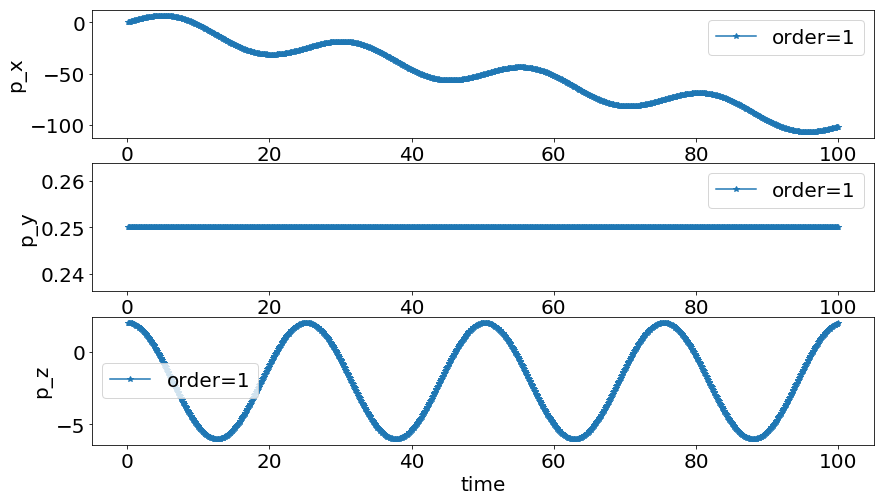

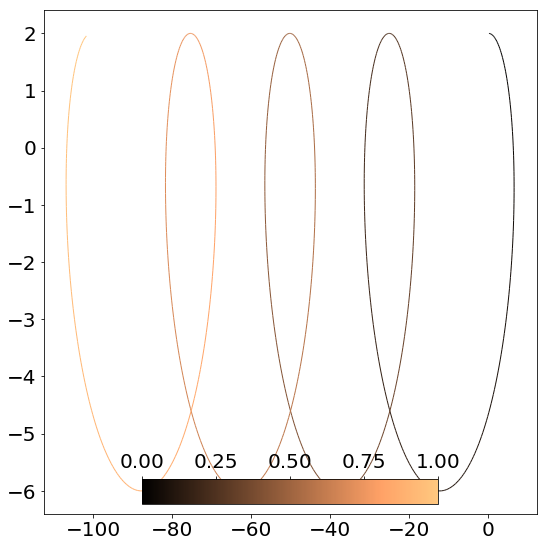

In [7]:
%matplotlib inline
importlib.reload(jm)
importlib.reload(spf)

fileHandle = 'ShearJefferyProblem'
job_dir = 'head_shear1c'
update_order_list = [1]
fig = plt.figure(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(3, 1, 1)
ax1 = fig.add_subplot(3, 1, 2)
ax2 = fig.add_subplot(3, 1, 3)
fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor('white')
ax3 = fig.add_subplot(1, 1, 1)

talpha = 1 / 1
ellipse_velocity = 1
tnorm = np.array((1, 0, 0))
lateral_norm = np.array((0, 0, 1))
tcenter = np.array((0, 0, 2))
planeShearRate = np.array((0.5, 0, 0))
for update_order in update_order_list:
    job_name = 'eq_a00.10_o%1d' % update_order
    mat_path = os.path.join(PWD, job_dir, job_name)
    mat_contents = loadmat(mat_path)
    ecoli_center = mat_contents['ecoli_center']
    ecoli_norm = mat_contents['ecoli_norm']
    ecoli_U = mat_contents['ecoli_U']
    eval_t = mat_contents['t'].flatten()

    eval_dt = np.mean(np.diff(eval_t))
    max_iter = eval_t.size // 10
    problem = jm.ShearJefferyProblem(planeShearRate=planeShearRate)

    ellipse_kwargs = {'name':          job_name,
                      'center':        tcenter,
                      'norm':          tnorm / np.linalg.norm(tnorm),
                      'lateral_norm':  lateral_norm / np.linalg.norm(lateral_norm),
                      'speed':         ellipse_velocity,
                      'lbd':           (talpha ** 2 - 1) / (talpha ** 2 + 1)}
    ellipse_obj = jm.JefferyObj(**ellipse_kwargs)
    ellipse_obj.set_update_para(fix_x=False, fix_y=False, fix_z=False, update_fun=Adams_Bashforth_Methods, update_order=update_order)
    problem.add_obj(ellipse_obj)

    # evaluation loop
    t0 = time()
    for idx in range(1, max_iter + 1):
        problem.update_location(eval_dt, print_handle='%d / %d' % (idx, max_iter))
    t1 = time()
    print('%s: run %d loops using %f' % (fileHandle, max_iter, (t1 - t0)))

    t0 = np.arange(max_iter) * eval_dt + eval_dt
    center_hist = np.vstack(ellipse_obj.center_hist)
    U_hist = np.vstack(ellipse_obj.U_hist)
    norm_hist = np.vstack(ellipse_obj.norm_hist)
#     ax0.plot(t0, norm_hist[:, 0], label='order=%1d' % update_order)
#     ax1.plot(t0, norm_hist[:, 1], label='order=%1d' % update_order)
#     ax2.plot(t0, norm_hist[:, 2], label='order=%1d' % update_order)
#     ax0.plot(eval_t, ecoli_norm[:, 0], label='order=%1d' % update_order)
#     ax1.plot(eval_t, ecoli_norm[:, 1], label='order=%1d' % update_order)
#     ax2.plot(eval_t, ecoli_norm[:, 2], label='order=%1d' % update_order)
    ax0.plot(t0, center_hist[:, 0], '-*', label='order=%1d' % update_order)
#     ax1.plot(t0, center_hist[:, 1], '-*', label='order=%1d' % update_order)
    ax1.plot(t0, np.linalg.norm(U_hist[:, 3:], axis=1), '-*', label='order=%1d' % update_order)
    ax2.plot(t0, center_hist[:, 2], '-*', label='order=%1d' % update_order)
    for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
        axi.set_xlabel('time')
        axi.set_ylabel('p_%s' % axyi)
        axi.legend()
    # ax0.set_xlim(900, 1000)
    plt.tight_layout()
    line1, = ax3.plot(center_hist[:, 0], center_hist[:, 2], label='order=%1d' % update_order)
    line1.remove()
    lc = spf.colorline(center_hist[:, 0], center_hist[:, 2], ax=ax3, linewidth=1)
#     ax3.set_xlim(-4, 4)
#     ax3.set_ylim(-4, 4)
    cbaxes = inset_axes(ax3, width="60%", height="5%", loc=8) 
    plt.colorbar(lc, cax=cbaxes, orientation='horizontal')
    cbaxes.xaxis.set_ticks_position('top')
    plt.tight_layout()

# fig = plt.figure(figsize=(14, 8))
# fig.patch.set_facecolor('white')
# ax0 = fig.add_subplot(3, 1, 1)
# ax1 = fig.add_subplot(3, 1, 2)
# ax2 = fig.add_subplot(3, 1, 3)
# t0 = np.arange(max_iter) * eval_dt + eval_dt
# center_hist = np.vstack(ellipse_obj.center_hist)
# U_hist = np.vstack(ellipse_obj.U_hist)
# norm_hist = np.vstack(ellipse_obj.norm_hist)
# ax0.plot(eval_t, (norm_hist[:, 0] - ecoli_norm[:, 0]))
# ax1.plot(eval_t, (norm_hist[:, 1] - ecoli_norm[:, 1]))
# ax2.plot(eval_t, (norm_hist[:, 2] - ecoli_norm[:, 2]))
# for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
#     axi.set_xlabel('time')
#     axi.set_ylabel('err_%s' % axyi)
#     # axi.legend()
# plt.tight_layout()

# t_stp = max_iter // 100
# fig = plt.figure(figsize=(8, 8))
# fig.patch.set_facecolor('white')
# ax0 = Axes3D(fig)
# # ax0 = fig.add_subplot(1, 1, 1, projection='3d')
# cm = plt.get_cmap('cool')
# color_len = center_hist[::t_stp, 0].size
# colors = [cm(1.*i/color_len) for i in range(color_len)]
# ax0.plot(center_hist[:, 0], center_hist[:, 1], center_hist[:, 2],)
# ax0.quiver(center_hist[::t_stp, 0], center_hist[::t_stp, 1], center_hist[::t_stp, 2], 
#            norm_hist[::t_stp, 0], norm_hist[::t_stp, 1], norm_hist[::t_stp, 2], 
#            length=0.0001*max_iter, arrow_length_ratio=0.2, pivot='middle', normalize=False, colors=colors)
# spf.set_axes_equal(ax0)
# ax0.set_xlabel('X')
# ax0.set_ylabel('Y')
# ax0.set_zlabel('Z')
# ax0.set_title('')



In [7]:
ecoli_U

array([[  1.27442e-02,  -3.98317e-03,   2.20334e-04,  -2.41054e-03,   9.70091e-01,
          6.55006e-04],
       [  1.26962e-02,  -4.08458e-03,   4.45958e-03,  -2.48395e-03,   9.70112e-01,
          9.21157e-04],
       [  1.27336e-02,  -4.18488e-03,   8.69931e-03,  -2.55300e-03,   9.70046e-01,
          1.18782e-03],
       [  1.28564e-02,  -4.28431e-03,   1.29377e-02,  -2.61784e-03,   9.69894e-01,
          1.45490e-03],
       [  1.30645e-02,  -4.38291e-03,   1.71725e-02,  -2.67852e-03,   9.69655e-01,
          1.72232e-03],
       [  1.33580e-02,  -4.48058e-03,   2.14019e-02,  -2.73500e-03,   9.69329e-01,
          1.98999e-03],
       [  1.37366e-02,  -4.57730e-03,   2.56240e-02,  -2.78726e-03,   9.68917e-01,
          2.25781e-03],
       [  1.42000e-02,  -4.67297e-03,   2.98373e-02,  -2.83523e-03,   9.68419e-01,
          2.52564e-03],
       [  1.47480e-02,  -4.76754e-03,   3.40399e-02,  -2.87889e-03,   9.67835e-01,
          2.79336e-03]])

ecoli_B01 9
eval_dt:  0.007
ShearJefferyProblem: run 9 loops using 0.001525


(array([ 0.    ,  0.0001,  0.0002,  0.0003,  0.0004,  0.0005,  0.0006,  0.0007,  0.0008,
         0.0009]), <a list of 10 Text yticklabel objects>)

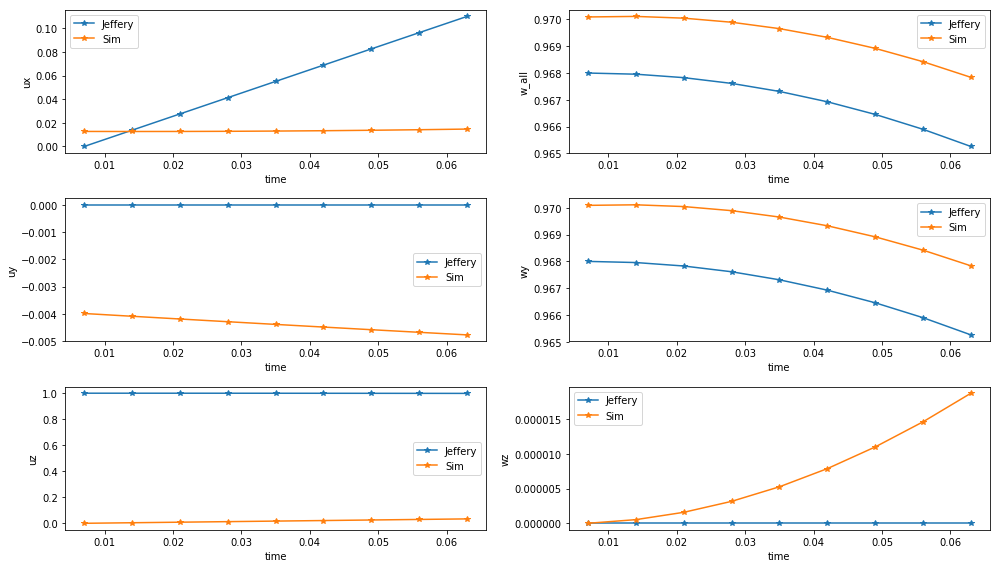

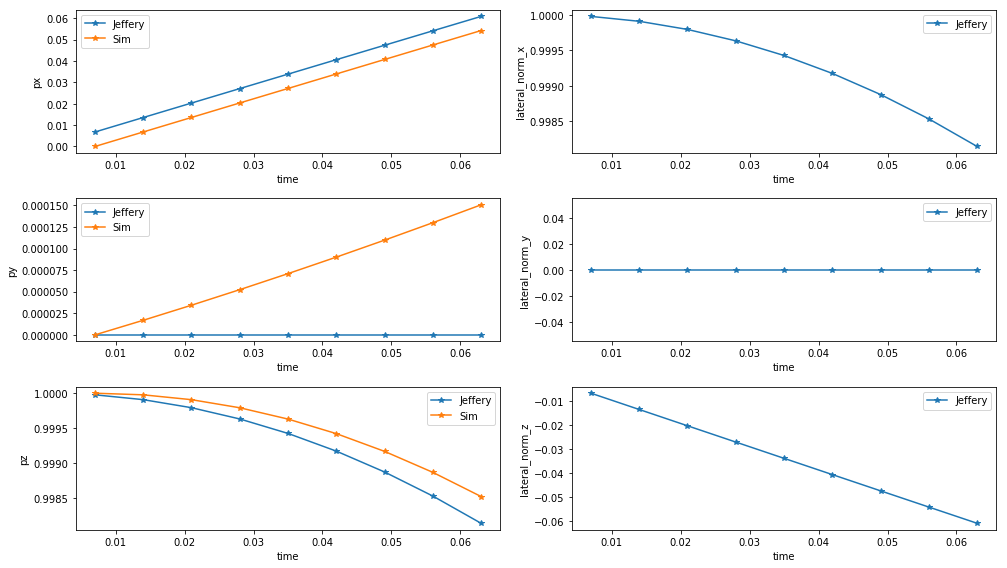

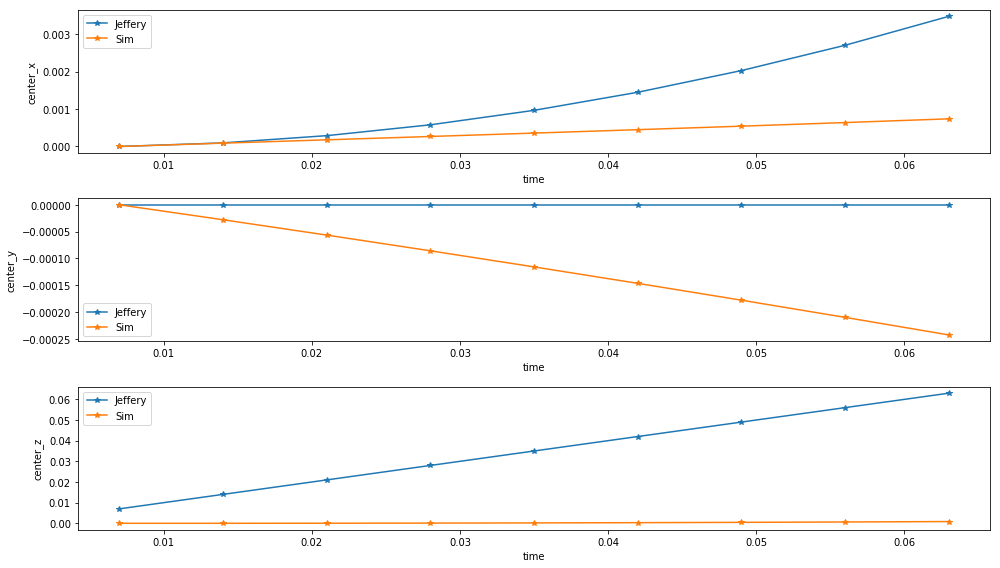

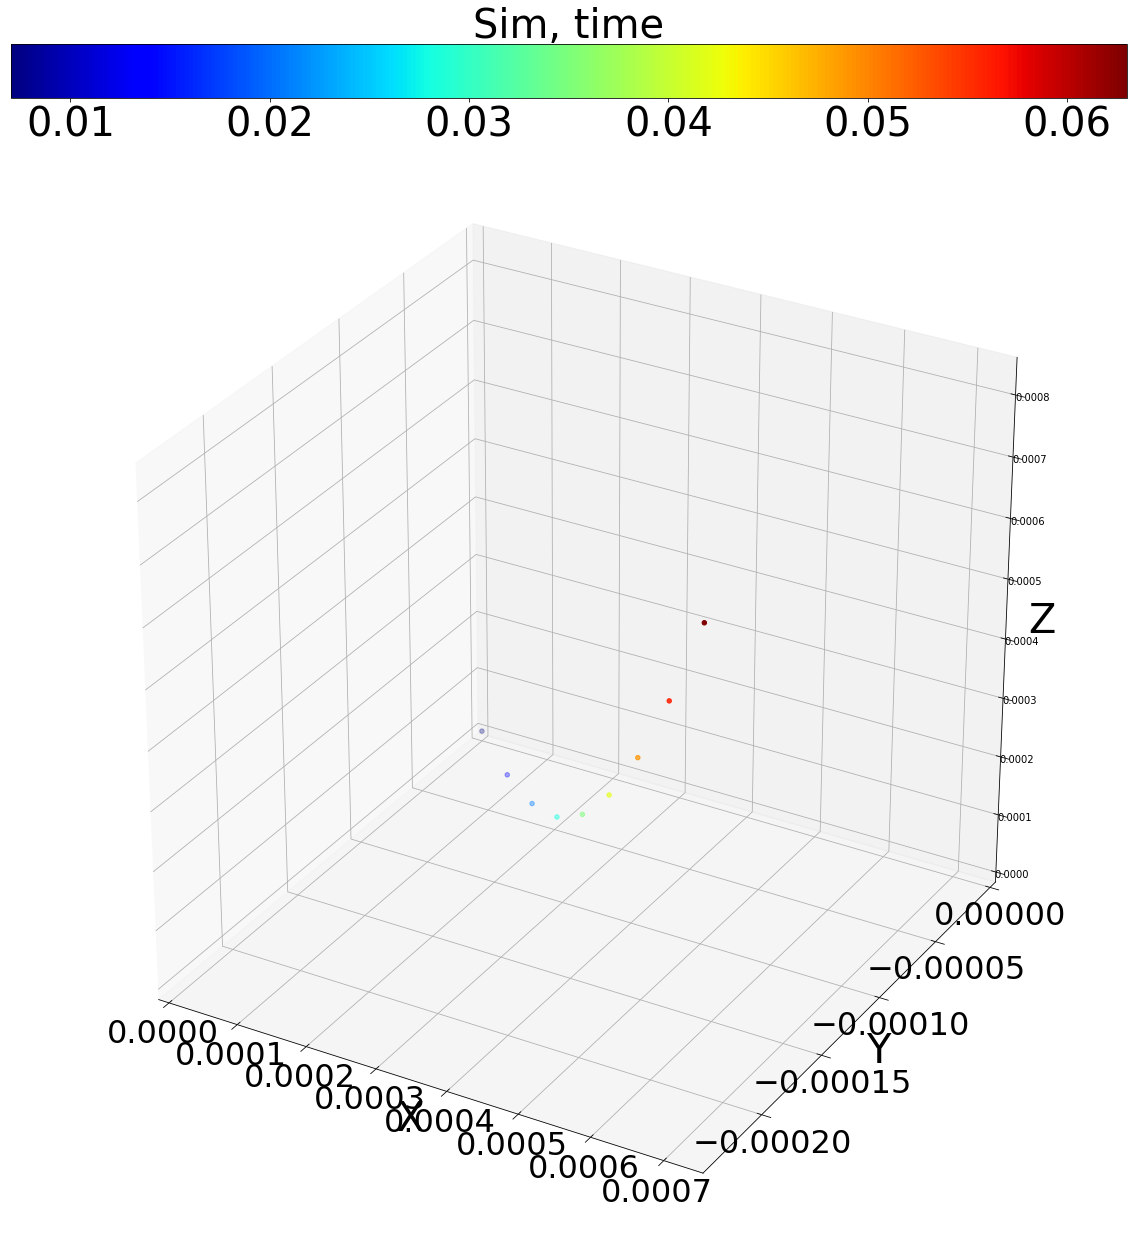

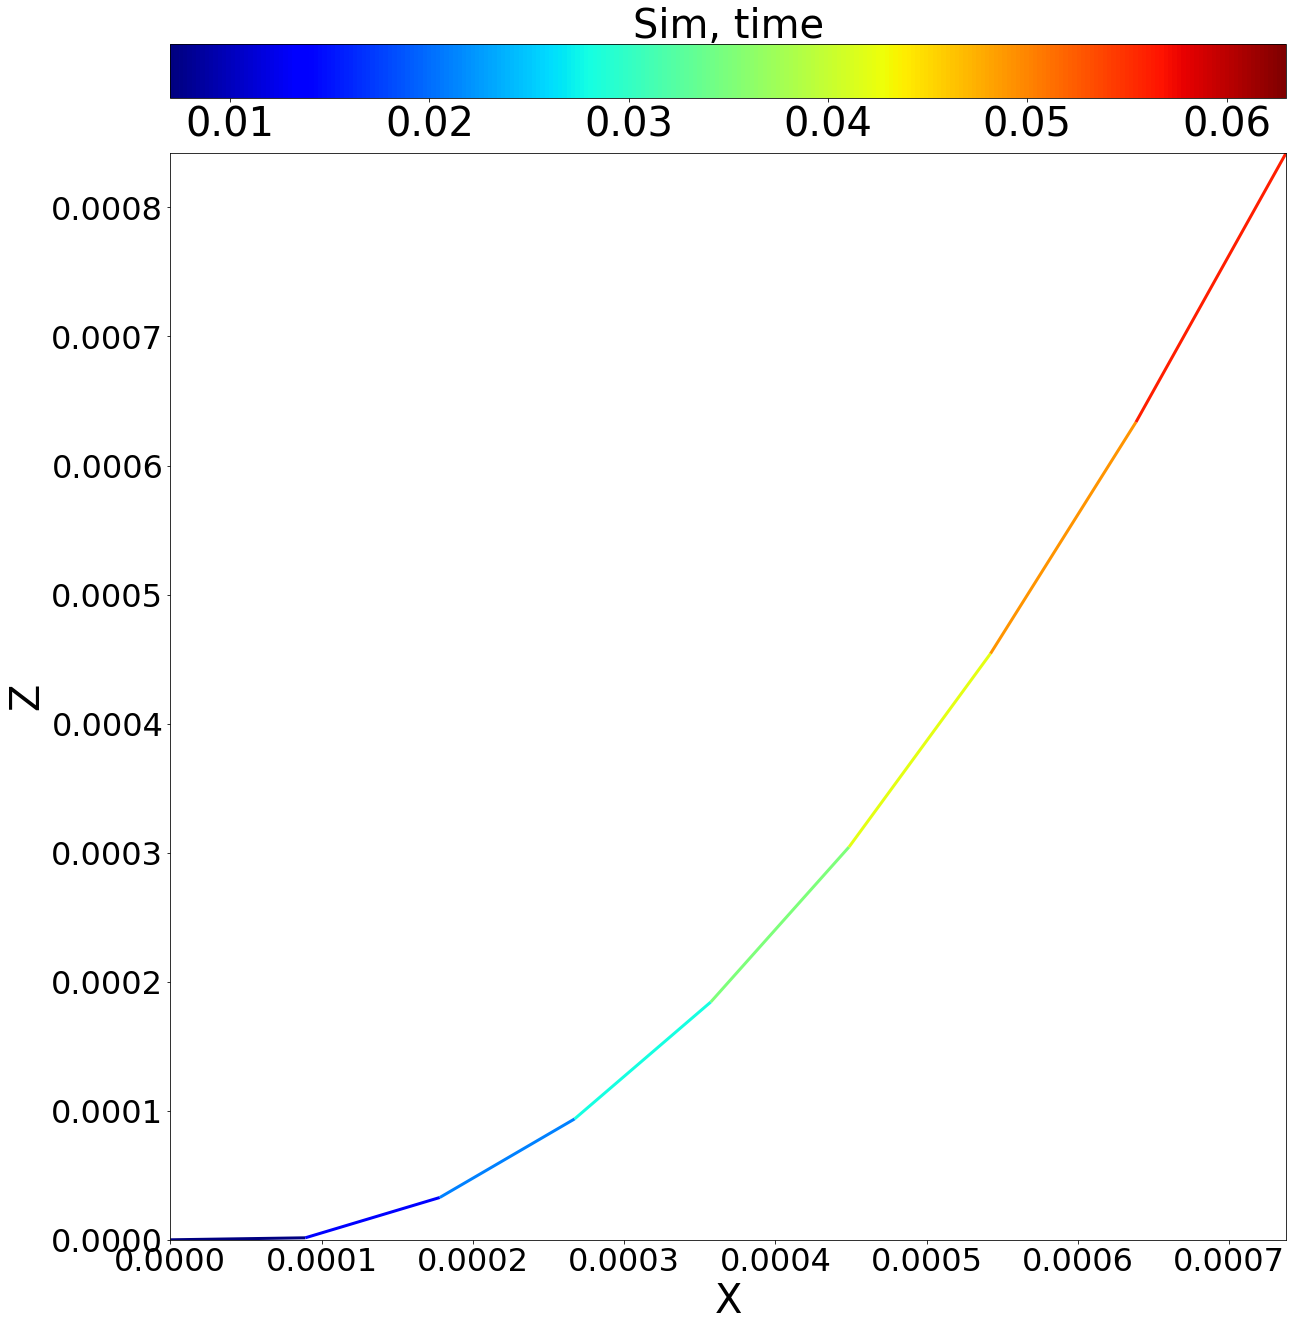

In [6]:
%matplotlib inline
# %matplotlib notebook

importlib.reload(jm)
fileHandle = 'ShearJefferyProblem'
file_handle = 'ecoli_B01'
dir_name = 'motion_ecoli_passive1/' + file_handle
talpha = 5.5
ellipse_velocity = 1
max_iter_fct = 1
eval_dt_fct = 1
tcenter = np.zeros(3)
tnorm = np.array((0, 0, 1))
# lateral_norm = np.array([0, 1, 0])
lateral_norm = np.array((1, 0, 0))
lateral_norm = lateral_norm - tnorm / np.linalg.norm(tnorm) * np.dot(tnorm, lateral_norm) / np.linalg.norm(lateral_norm)
lateral_norm = lateral_norm / np.linalg.norm(lateral_norm)
rot_speed = 0

t_dir = os.path.join(PWD, dir_name)
mat_names = natsort.natsorted(glob.glob('%s/%s_*.mat' % (t_dir, file_handle)))
print(file_handle, len(mat_names))
ecoli_U_list = []
ecoli_norm_list = []
ecoli_center_list = []
ecoli_nodes_list = []
ecoli_u_list = []
ecoli_f_list = []
ti_list = []
tail_rel_U_list = []
for mati in mat_names[:200]:
    mat_contents = loadmat(mati)
    ecoli_U = mat_contents['ecoli_U'].flatten()
    ecoli_norm = mat_contents['ecoli_norm'].flatten()
    ecoli_center = mat_contents['ecoli_center'].flatten()
    ecoli_nodes = mat_contents['ecoli_nodes']
    ecoli_u = mat_contents['ecoli_u']
    ecoli_f = mat_contents['ecoli_f']
    planeShearRate = mat_contents['planeShearRate'].flatten()
    ti = mat_contents['ti'].flatten()
    tail_rel_U = mat_contents['tail_rel_U'].flatten()
    ecoli_U_list.append(ecoli_U)
    ecoli_norm_list.append(ecoli_norm)
    ecoli_center_list.append(ecoli_center)
    ecoli_nodes_list.append(ecoli_nodes)
    ti_list.append(ti)
    tail_rel_U_list.append(tail_rel_U)
ecoli_U = np.vstack(ecoli_U_list)
ecoli_norm = np.vstack(ecoli_norm_list)
ecoli_center = np.vstack(ecoli_center_list)
eval_t = np.hstack(ti_list)
ecoli_t = eval_t
tail_rel_U = np.vstack(tail_rel_U_list)
omega_norm = np.array([np.dot(t1, t2)*t2/np.dot(t2, t2) for t1, t2 in zip(ecoli_U[:, 3:], ecoli_norm)])
omega_tang = ecoli_U[:, 3:] - omega_norm
# tnorm = ecoli_norm_list[0]
# tcenter = ecoli_center[0]

problem = jm.ShearJefferyProblem(planeShearRate=planeShearRate)
eval_dt = np.mean(np.diff(eval_t)) * eval_dt_fct
print('eval_dt: ', eval_dt)
max_iter = eval_t.size * max_iter_fct
ellipse_kwargs = {'name':          file_handle,
                  'center':        tcenter,
                  'rot_speed':     rot_speed,
                  'norm':          tnorm / np.linalg.norm(tnorm),
                  'lateral_norm':  lateral_norm / np.linalg.norm(lateral_norm),
                  'speed':         ellipse_velocity,
                  'lbd':           (talpha ** 2 - 1) / (talpha ** 2 + 1)}
ellipse_obj = jm.JefferyObj(**ellipse_kwargs)
# ellipse_obj.dbg_set_update_para(fix_x=0, fix_y=0, fix_z=0)
problem.add_obj(ellipse_obj)

# evaluation loop
t0 = time()
for idx in range(1, max_iter + 1):
    problem.update_location(eval_dt, print_handle='%d / %d' % (idx, max_iter))
t1 = time()
print('%s: run %d loops using %f' % (fileHandle, max_iter, (t1 - t0)))
t0 = np.arange(max_iter) * eval_dt + eval_dt
center_hist = np.vstack(ellipse_obj.center_hist)
U_hist = np.vstack(ellipse_obj.U_hist)
norm_hist = np.vstack(ellipse_obj.norm_hist)
lateral_norm_hist = np.vstack(ellipse_obj.lateral_norm_hist)

fig = plt.figure(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(3, 2, 1)
ax1 = fig.add_subplot(3, 2, 3)
ax2 = fig.add_subplot(3, 2, 5)
ax3 = fig.add_subplot(3, 2, 2)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 6)
# ax0.plot(t0, U_hist[:, 0], '-*', label='Jeffery')
# ax1.plot(t0, U_hist[:, 1], '-*', label='Jeffery')
# ax2.plot(t0, U_hist[:, 2], '-*', label='Jeffery')
# # ax3.plot(t0, U_hist[:, 3], '-*', label='Jeffery')
# ax4.plot(t0, np.linalg.norm(U_hist[:, 3:], axis=1), '-*', label='Jeffery')
# # ax5.plot(t0, U_hist[:, 5], '-*', label='Jeffery')
# ax0.plot(eval_t, ecoli_U[:, 0], '-*', label='Sim')
# ax1.plot(eval_t, ecoli_U[:, 1], '-*', label='Sim')
# ax2.plot(eval_t, ecoli_U[:, 2], '-*', label='Sim')
# ax3.plot(eval_t, np.linalg.norm(omega_norm, axis=1), '-*', label='Sim')
# ax4.plot(eval_t, np.linalg.norm(omega_tang, axis=1), '-*', label='Sim')
# ax5.plot(eval_t, np.linalg.norm(ecoli_U[:, 3:], axis=1), '-*', label='Sim')
# for axi, axyi in zip((ax0, ax1, ax2, ax3, ax4, ax5, ), ('ux', 'uy', 'uz', 'omega_norm', 'omega_tang', 'omega_all')):
#     axi.set_xlabel('time')
#     axi.set_ylabel(axyi)
#     axi.legend()
ax0.plot(t0, U_hist[:, 0], '-*', label='Jeffery')
ax1.plot(t0, U_hist[:, 1], '-*', label='Jeffery')
ax2.plot(t0, U_hist[:, 2], '-*', label='Jeffery')
ax3.plot(t0, np.linalg.norm(U_hist[:, 3:], axis=1), '-*', label='Jeffery')
ax4.plot(t0, U_hist[:, 4], '-*', label='Jeffery')
ax5.plot(t0, U_hist[:, 5], '-*', label='Jeffery')
ax0.plot(eval_t, ecoli_U[:, 0], '-*', label='Sim')
ax1.plot(eval_t, ecoli_U[:, 1], '-*', label='Sim')
ax2.plot(eval_t, ecoli_U[:, 2], '-*', label='Sim')
ax3.plot(eval_t, np.linalg.norm(omega_tang[:, :], axis=1), '-*', label='Sim')
ax4.plot(eval_t, omega_tang[:, 1], '-*', label='Sim')
ax5.plot(eval_t, omega_tang[:, 2], '-*', label='Sim')
for axi, axyi in zip((ax0, ax1, ax2, ax3, ax4, ax5, ), ('ux', 'uy', 'uz', 'w_all', 'wy', 'wz')):
    axi.set_xlabel('time')
    axi.set_ylabel(axyi)
    axi.legend()
plt.tight_layout()

fig = plt.figure(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(3, 2, 1)
ax1 = fig.add_subplot(3, 2, 3)
ax2 = fig.add_subplot(3, 2, 5)
ax3 = fig.add_subplot(3, 2, 2)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 6)
ax0.plot(t0, norm_hist[:, 0], '-*', label='Jeffery')
ax1.plot(t0, norm_hist[:, 1], '-*', label='Jeffery')
ax2.plot(t0, norm_hist[:, 2], '-*', label='Jeffery')
ax3.plot(t0, lateral_norm_hist[:, 0], '-*', label='Jeffery')
ax4.plot(t0, lateral_norm_hist[:, 1], '-*', label='Jeffery')
ax5.plot(t0, lateral_norm_hist[:, 2], '-*', label='Jeffery')
ax0.plot(eval_t, ecoli_norm[:, 0], '-*', label='Sim')
ax1.plot(eval_t, ecoli_norm[:, 1], '-*', label='Sim')
ax2.plot(eval_t, ecoli_norm[:, 2], '-*', label='Sim')
for axi, axyi in zip((ax0, ax1, ax2, ax3, ax4, ax5, ), ('px', 'py', 'pz', 'lateral_norm_x', 'lateral_norm_y', 'lateral_norm_z')):
    axi.set_xlabel('time')
    axi.set_ylabel('%s' % axyi)
    axi.legend()
plt.tight_layout()

# fig = plt.figure(figsize=(14, 8))
# fig.patch.set_facecolor('white')
# ax0 = fig.add_subplot(3, 1, 1)
# ax1 = fig.add_subplot(3, 1, 2)
# ax2 = fig.add_subplot(3, 1, 3)
# ax0.plot(eval_t, (norm_hist[:, 0] - ecoli_norm[:, 0]))
# ax1.plot(eval_t, (norm_hist[:, 1] - ecoli_norm[:, 1]))
# ax2.plot(eval_t, (norm_hist[:, 2] - ecoli_norm[:, 2]))
# for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
#     axi.set_xlabel('time')
#     axi.set_ylabel('err_%s' % axyi)
# #     axi.legend()
# plt.tight_layout()

fig = plt.figure(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(3, 1, 1)
ax1 = fig.add_subplot(3, 1, 2)
ax2 = fig.add_subplot(3, 1, 3)
ax0.plot(t0, center_hist[:, 0],  '-*', label='Jeffery')
ax1.plot(t0, center_hist[:, 1],  '-*', label='Jeffery')
ax2.plot(t0, center_hist[:, 2],  '-*', label='Jeffery')
ax0.plot(eval_t, ecoli_center[:, 0],  '-*', label='Sim')
ax1.plot(eval_t, ecoli_center[:, 1],  '-*', label='Sim')
ax2.plot(eval_t, ecoli_center[:, 2],  '-*', label='Sim')
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    axi.set_xlabel('time')
    axi.set_ylabel('center_%s' % axyi)
    axi.legend()
plt.tight_layout()

# fig = plt.figure(figsize=(14, 8))
# fig.patch.set_facecolor('white')
# ax0 = fig.add_subplot(4, 1, 1)
# ax1 = fig.add_subplot(4, 1, 2)
# ax2 = fig.add_subplot(4, 1, 3)
# ax3 = fig.add_subplot(4, 1, 4)
# ax0.plot(eval_t, tail_rel_U[:, 3],  '-*', label='Sim')
# ax1.plot(eval_t, tail_rel_U[:, 4],  '-*', label='Sim')
# ax2.plot(eval_t, tail_rel_U[:, 5],  '-*', label='Sim')
# ax3.plot(eval_t, np.linalg.norm(tail_rel_U[:, 3:], axis=1),  '-*', label='Sim')
# for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
#     axi.set_xlabel('time')
#     axi.set_ylabel('tail_rel_w_%s' % axyi)
#     axi.legend()
# plt.tight_layout()

# t_data = U_hist[:, 4]
# ecoli_fft = np.fft.rfft(t_data)
# ecoli_freq = np.fft.rfftfreq(t_data.size, np.mean(np.diff(eval_t)))
# t_data = omega_tang[:, 1]
# Jeffery_fft = np.fft.rfft(t_data)
# Jeffery_freq = np.fft.rfftfreq(t_data.size, eval_dt)
# fig = plt.figure(figsize=(14, 8))
# fig.patch.set_facecolor('white')
# ax0 = fig.add_subplot(2, 1, 1)
# ax1 = fig.add_subplot(2, 1, 2)
# ax0.plot(ecoli_freq, np.abs(ecoli_fft), '-*')
# ax0.set_xlim(0, 10)
# ax0.set_xlabel('Freq (Hz)')
# ax0.set_ylabel('Amplitude')
# ax1.plot(Jeffery_freq, np.abs(Jeffery_fft), '-*')
# ax1.set_xlim(0, 10)
# ax1.set_xlabel('Freq (Hz)')
# ax1.set_ylabel('Amplitude')
# plt.tight_layout()

# t_stp = max_iter // 100
# fig = plt.figure(figsize=(8, 8))
# fig.patch.set_facecolor('white')
# ax0 = Axes3D(fig)
# # ax0 = fig.add_subplot(1, 1, 1, projection='3d')
# cm = plt.get_cmap('cool')
# color_len = center_hist[::t_stp, 0].size
# colors = [cm(1.*i/color_len) for i in range(color_len)]
# ax0.plot(center_hist[:, 0], center_hist[:, 1], center_hist[:, 2],)
# ax0.quiver(center_hist[::t_stp, 0], center_hist[::t_stp, 1], center_hist[::t_stp, 2], 
#            norm_hist[::t_stp, 0], norm_hist[::t_stp, 1], norm_hist[::t_stp, 2], 
#            length=0.001*max_iter, arrow_length_ratio=0.2, pivot='middle', normalize=False, colors=colors)
# spf.set_axes_equal(ax0)
# ax0.set_xlabel('X')
# ax0.set_ylabel('Y')
# ax0.set_zlabel('Z')
# ax0.set_title('')

fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1, projection='3d')
cax1 = inset_axes(ax0, width="100%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=1, bbox_transform=ax0.transAxes, borderpad=0,)
norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
cmap=plt.get_cmap('jet')
lc = ax0.scatter(ecoli_center[:, 0], ecoli_center[:, 1], ecoli_center[:, 2], 
                 c=ecoli_t, cmap=cmap, norm=norm)
clb = fig.colorbar(lc, cax=cax1, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Sim, time', size=fontsize)
ax0.set_xlim((ecoli_center[:, 0].min(), ecoli_center[:, 0].max()))
ax0.set_ylim((ecoli_center[:, 1].min(), ecoli_center[:, 1].max()))
ax0.set_zlim((ecoli_center[:, 2].min(), ecoli_center[:, 2].max()))
plt.sca(ax0)
for spine in ax0.spines.values(): spine.set_visible(False)
ax0.set_xlabel('X', size=fontsize)
ax0.set_ylabel('Y', size=fontsize)
ax0.set_zlabel('Z', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
    
fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)
cax1 = inset_axes(ax0, width="100%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=1, bbox_transform=ax0.transAxes, borderpad=0,)
norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
cmap=plt.get_cmap('jet')
lc = spf.colorline(ecoli_center[:, 0], ecoli_center[:, 2], ecoli_t, ax=ax0, cmap=cmap, norm=norm, linewidth=3)
clb = fig.colorbar(lc, cax=cax1, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Sim, time', size=fontsize)
ax0.set_xlim((ecoli_center[:, 0].min(), ecoli_center[:, 0].max()))
ax0.set_ylim((ecoli_center[:, 2].min(), ecoli_center[:, 2].max()))
plt.sca(ax0)
ax0.set_xlabel('X', size=fontsize)
ax0.set_ylabel('Z', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)

dbg_tau10.00 18383
ShearJefferyProblem: run 3000 loops using 0.379987


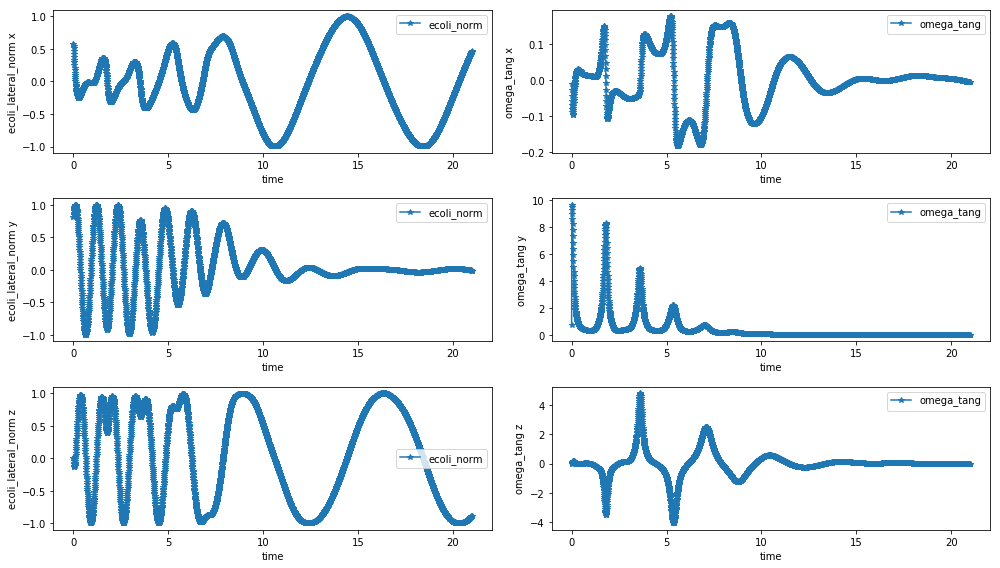

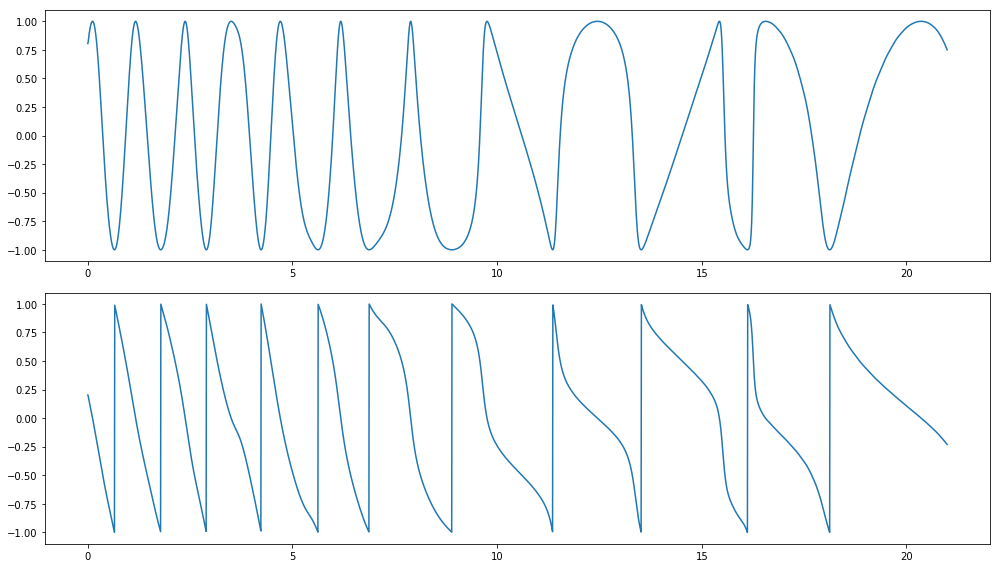

In [7]:
%matplotlib inline
# %matplotlib notebook

importlib.reload(jm)
fileHandle = 'ShearJefferyProblem'
file_handle = 'dbg_tau10.00'
dir_name = 'motion_ecoli_torque6/' + file_handle
talpha = 5.5
ellipse_velocity = 1
max_iter_fct = 1
eval_dt_fct = 3
tcenter = np.zeros(3)
tnorm = np.array((0, 0, 1))
# lateral_norm = np.array([0, 1, 0])
lateral_norm = np.array([-0.01562, 0.99988, 0])
rot_speed = 0

t_dir = os.path.join(PWD, dir_name)
mat_names = natsort.natsorted(glob.glob('%s/%s_*.mat' % (t_dir, file_handle)))
print(file_handle, len(mat_names))
ecoli_U_list = []
ecoli_norm_list = []
ecoli_center_list = []
ecoli_nodes_list = []
ecoli_u_list = []
ecoli_f_list = []
ti_list = []
tail_rel_U_list = []
ecoli_lateral_norm_list = []
# lateral_norm_node_idx = 3000
for mati in mat_names[:3000]:
    mat_contents = loadmat(mati)
    ecoli_U = mat_contents['ecoli_U'].flatten()
    ecoli_norm = mat_contents['ecoli_norm'].flatten()
    ecoli_center = mat_contents['ecoli_center'].flatten()
    ecoli_nodes = mat_contents['ecoli_nodes']
    ecoli_u = mat_contents['ecoli_u']
    ecoli_f = mat_contents['ecoli_f']
    planeShearRate = mat_contents['planeShearRate'].flatten()
    ti = mat_contents['ti'].flatten()
    tail_rel_U = mat_contents['tail_rel_U'].flatten()
    ecoli_U_list.append(ecoli_U)
    ecoli_norm_list.append(ecoli_norm)
    ecoli_center_list.append(ecoli_center)
    ecoli_nodes_list.append(ecoli_nodes)
    ti_list.append(ti)
    tail_rel_U_list.append(tail_rel_U)
    r0 = ecoli_nodes[-1] - ecoli_center
    n0 = np.dot(r0, ecoli_norm) * ecoli_norm / np.dot(ecoli_norm, ecoli_norm)
    t0 = r0 - n0
    ecoli_lateral_norm_list.append(t0 / np.linalg.norm(t0))
ecoli_U = np.vstack(ecoli_U_list)
ecoli_norm = np.vstack(ecoli_norm_list)
ecoli_center = np.vstack(ecoli_center_list)
eval_t = np.hstack(ti_list)
tail_rel_U = np.vstack(tail_rel_U_list)
ecoli_lateral_norm = np.vstack(ecoli_lateral_norm_list)
using_U = ecoli_U + tail_rel_U
omega_norm = np.array([np.dot(t1, t2)*t2/np.dot(t2, t2) for t1, t2 in zip(using_U[:, 3:], ecoli_norm)])
omega_tang = using_U[:, 3:] - omega_norm
# tnorm = ecoli_norm_list[0]
# tcenter = ecoli_center[0]

problem = jm.ShearJefferyProblem(planeShearRate=planeShearRate)
eval_dt = np.mean(np.diff(eval_t)) * eval_dt_fct
max_iter = eval_t.size * max_iter_fct
ellipse_kwargs = {'name':          file_handle,
                  'center':        tcenter,
                  'rot_speed':     rot_speed,
                  'norm':          tnorm / np.linalg.norm(tnorm),
                  'lateral_norm':  lateral_norm / np.linalg.norm(lateral_norm),
                  'speed':         ellipse_velocity,
                  'lbd':           (talpha ** 2 - 1) / (talpha ** 2 + 1)}
ellipse_obj = jm.JefferyObj(**ellipse_kwargs)
problem.add_obj(ellipse_obj)

# evaluation loop
t0 = time()
for idx in range(1, max_iter + 1):
    problem.update_location(eval_dt, print_handle='%d / %d' % (idx, max_iter))
t1 = time()
print('%s: run %d loops using %f' % (fileHandle, max_iter, (t1 - t0)))
t0 = np.arange(max_iter) * eval_dt + eval_dt
center_hist = np.vstack(ellipse_obj.center_hist)
U_hist = np.vstack(ellipse_obj.U_hist)
norm_hist = np.vstack(ellipse_obj.norm_hist)
lateral_norm_hist = np.vstack(ellipse_obj.lateral_norm_hist)

fig = plt.figure(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(3, 2, 1)
ax1 = fig.add_subplot(3, 2, 3)
ax2 = fig.add_subplot(3, 2, 5)
ax3 = fig.add_subplot(3, 2, 2)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 6)
ax0.plot(eval_t, ecoli_lateral_norm[:, 0], '-*', label='ecoli_norm')
ax1.plot(eval_t, ecoli_lateral_norm[:, 1], '-*', label='ecoli_norm')
ax2.plot(eval_t, ecoli_lateral_norm[:, 2], '-*', label='ecoli_norm')
ax3.plot(eval_t, omega_tang[:, 0], '-*', label='omega_tang')
ax4.plot(eval_t, omega_tang[:, 1], '-*', label='omega_tang')
ax5.plot(eval_t, omega_tang[:, 2], '-*', label='omega_tang')
for axi, axyi in zip((ax0, ax1, ax2, ax3, ax4, ax5, ), 
                      ('ecoli_lateral_norm x', 'ecoli_lateral_norm y', 'ecoli_lateral_norm z', 
                        'omega_tang x', 'omega_tang y', 'omega_tang z')):
    axi.set_xlabel('time')
    axi.set_ylabel('%s' % axyi)
    axi.legend()
plt.tight_layout()

fig = plt.figure(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(2, 1, 1)
ax1 = fig.add_subplot(2, 1, 2)
cos_theta  = np.array([np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v) for u, v in zip(ecoli_lateral_norm, omega_tang)])
angle_sign = np.sign(np.array([np.dot(np.cross(u, v), w) for u, v, w in zip(ecoli_lateral_norm, omega_tang, ecoli_norm)]))
ax0.plot(eval_t, cos_theta)
ax1.plot(eval_t, np.arccos(cos_theta) / np.pi * angle_sign)
plt.tight_layout()


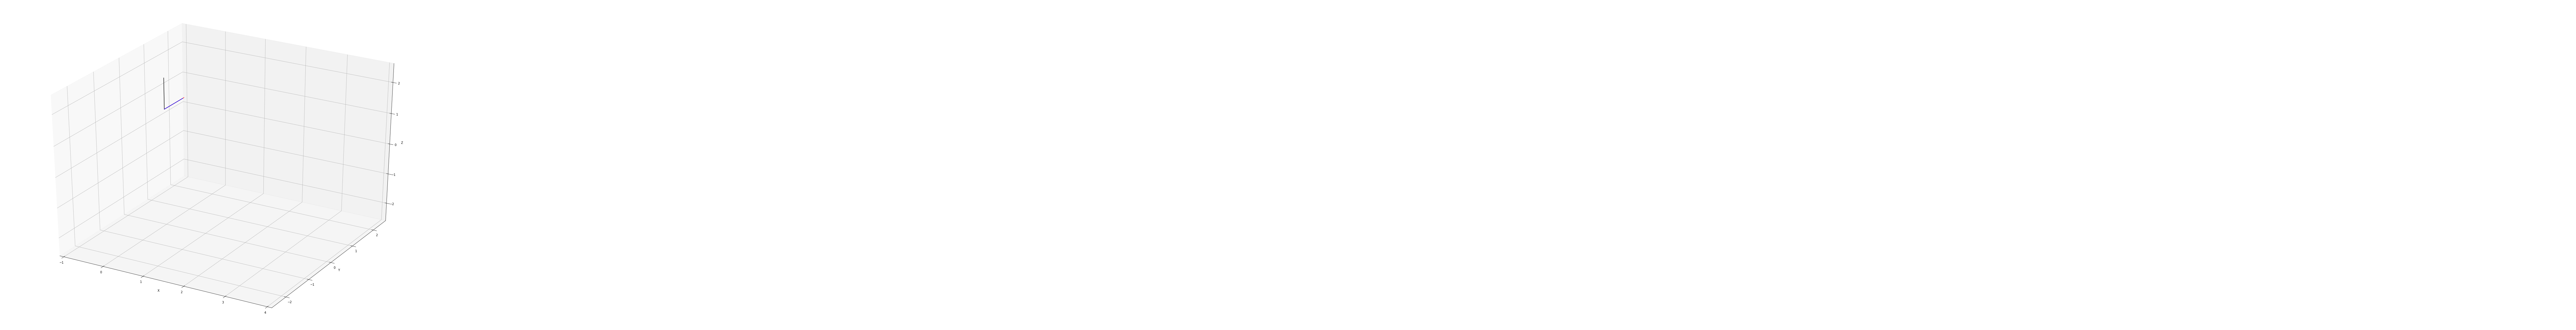

In [12]:
fig = plt.figure(figsize=(20, 15))
fig.patch.set_facecolor('white')
ax = axes3d.Axes3D(fig)

tecoli_center = ecoli_center[0]
tecoli_lateral_norm = ecoli_lateral_norm[0]
tecoli_norm = ecoli_norm[0]
tomega_tang = omega_tang[0]
tmp_line1 = ax.plot([tecoli_center[0], tecoli_center[0] + tecoli_norm[0]], 
                    [tecoli_center[1], tecoli_center[1] + tecoli_norm[1]],
                    [tecoli_center[2], tecoli_center[2] + tecoli_norm[2]], color='k')[0]
tmp_line2 = ax.plot([tecoli_center[0], tecoli_center[0] + tecoli_lateral_norm[0]], 
                    [tecoli_center[1], tecoli_center[1] + tecoli_lateral_norm[1]],
                    [tecoli_center[2], tecoli_center[2] + tecoli_lateral_norm[2]], color='r')[0]
tmp_line3 = ax.plot([tecoli_center[0], tecoli_center[0] + tomega_tang[0]], 
                    [tecoli_center[1], tecoli_center[1] + tomega_tang[1]],
                    [tecoli_center[2], tecoli_center[2] + tomega_tang[2]], color='b')[0]
ax.set_xlim3d([-1, 4])
ax.set_xlabel('X')
ax.set_ylim3d([-2.5, 2.5])
ax.set_ylabel('Y')
ax.set_zlim3d([-2.5, 2.5])
ax.set_zlabel('Z')

def update_fun(num, tl1, tl2, tl3, ecoli_center, ecoli_norm, ecoli_lateral_norm, omega_tang):
    t1 = np.vstack([ecoli_center[num], ecoli_center[num] + ecoli_norm[num]])
    tl1.set_data(t1[:, 0], t1[:, 1])
    tl1.set_3d_properties(t1[:, 2])
    t2 = np.vstack([ecoli_center[num], ecoli_center[num] + ecoli_lateral_norm[num]])
    tl2.set_data(t1[:, 0], t2[:, 1])
    tl2.set_3d_properties(t2[:, 2])
    t3 = np.vstack([ecoli_center[num], ecoli_center[num] + omega_tang[num]])
    tl3.set_data(t1[:, 0], t3[:, 1])
    tl3.set_3d_properties(t3[:, 2])
    return tl1, tl2, tl3, 

anim = animation.FuncAnimation(fig, update_fun, len(ecoli_center), interval=50, blit=False, 
                               fargs=(tmp_line1, tmp_line2, tmp_line3, 
                                      ecoli_center, ecoli_norm, ecoli_lateral_norm, omega_tang), )
anim


dbg_tau10.00 18383


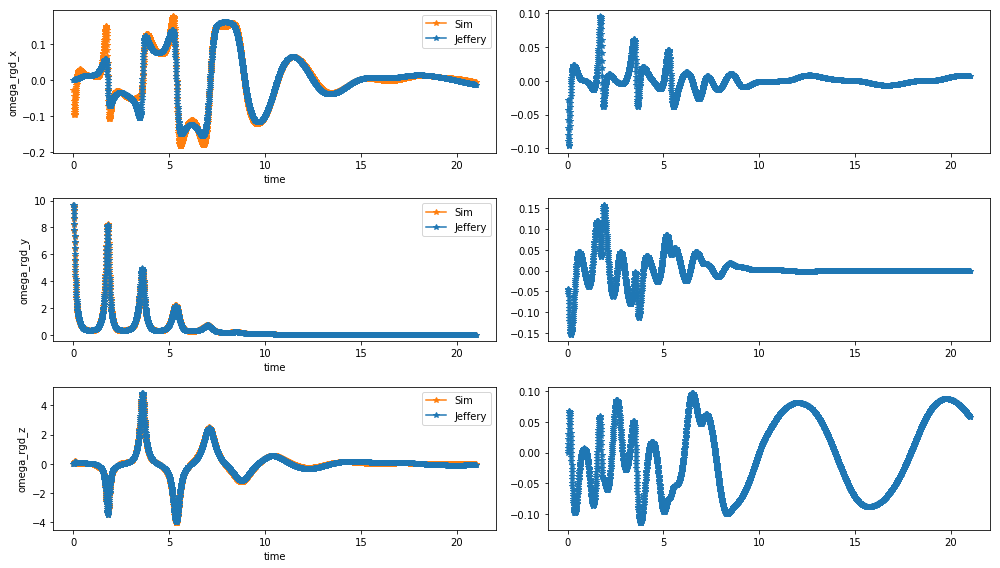

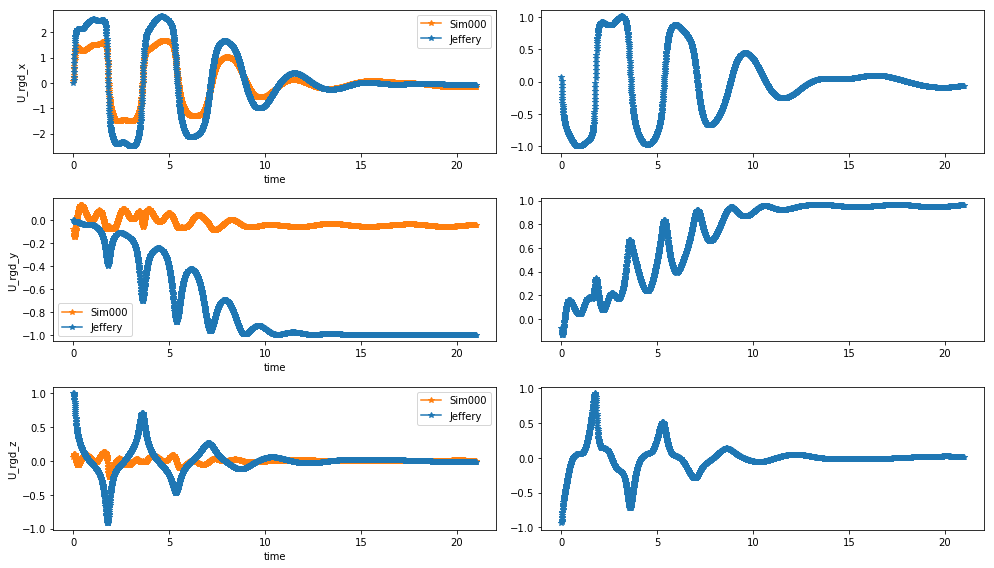

In [281]:
%matplotlib inline
# %matplotlib notebook

# read the simulation data, and do Jeffery simulation, 
#  1). alpha=(2*rs1+dist_hs+ch*ph)/rs2
#  2). at each position, calculate the rotation of swimmer and ellipes, find the difference. 

importlib.reload(jm)
fileHandle = 'ShearJefferyProblem'
file_handle = 'dbg_tau10.00'
dir_name = 'motion_ecoli_torque6/' + file_handle
talpha = 5.5
ellipse_velocity = 1
max_iter_fct = 1
eval_dt_fct = 3
tcenter = np.zeros(3)
tnorm = np.array((0, 0, 1))
# lateral_norm = np.array([0, 1, 0])
lateral_norm = np.array([-0.01562, 0.99988, 0])
rot_speed = 0

t_dir = os.path.join(PWD, dir_name)
mat_names = natsort.natsorted(glob.glob('%s/%s_*.mat' % (t_dir, file_handle)))
print(file_handle, len(mat_names))
ecoli_U_list = []
ecoli_norm_list = []
ecoli_center_list = []
ecoli_nodes_list = []
ecoli_u_list = []
ecoli_f_list = []
ti_list = []
tail_rel_U_list = []
ecoli_lateral_norm_list = []
# lateral_norm_node_idx = 3000
for mati in mat_names[1:3000]:
    mat_contents = loadmat(mati)
    ecoli_U = mat_contents['ecoli_U'].flatten()
    ecoli_norm = mat_contents['ecoli_norm'].flatten()
    ecoli_center = mat_contents['ecoli_center'].flatten()
    ecoli_nodes = mat_contents['ecoli_nodes']
    ecoli_u = mat_contents['ecoli_u']
    ecoli_f = mat_contents['ecoli_f']
    planeShearRate = mat_contents['planeShearRate'].flatten()
    ti = mat_contents['ti'].flatten()
    tail_rel_U = mat_contents['tail_rel_U'].flatten()
    ecoli_U_list.append(ecoli_U)
    ecoli_norm_list.append(ecoli_norm)
    ecoli_center_list.append(ecoli_center)
    ecoli_nodes_list.append(ecoli_nodes)
    ti_list.append(ti)
    tail_rel_U_list.append(tail_rel_U)
    r0 = ecoli_nodes[-1] - ecoli_center
    n0 = np.dot(r0, ecoli_norm) * ecoli_norm / np.dot(ecoli_norm, ecoli_norm)
    t0 = r0 - n0
    ecoli_lateral_norm_list.append(t0 / np.linalg.norm(t0))
ecoli_norm = np.vstack(ecoli_norm_list)
ecoli_center = np.vstack(ecoli_center_list)
eval_t = np.hstack(ti_list)
tail_rel_U = np.vstack(tail_rel_U_list)
ecoli_lateral_norm = np.vstack(ecoli_lateral_norm_list)
ecoli_U = np.vstack(ecoli_U_list)
# calculate velocity u000(t,x,y,z) that the location initially at (0, 0, 0): u000(0, 0, 0, 0)
n_u000 = -np.linalg.norm(ecoli_center[0] - tcenter) * ecoli_norm
ecoli_u000 = ecoli_U[:, :3] + np.cross(ecoli_U[:, 3:], n_u000)
# calculate center center000(t,x,y,z) that at initially at (0, 0, 0): center000(0, 0, 0, 0)
ecoli_center000 = ecoli_center + n_u000
using_U = ecoli_U + tail_rel_U
omega_norm = np.array([np.dot(t1, t2)*t2/np.dot(t2, t2) for t1, t2 in zip(using_U[:, 3:], ecoli_norm)])
omega_tang = using_U[:, 3:] - omega_norm
# tnorm = ecoli_norm_list[0]
# tcenter = ecoli_center[0]
DC_norm = np.vstack([(1 - spatial.distance.cosine(t0, (1, 0, 0)), # Direction cosine of ecoli_norm
                      1 - spatial.distance.cosine(t0, (0, 1, 0)), 
                      1 - spatial.distance.cosine(t0, (0, 0, 1))) for t0 in ecoli_norm])

problem = jm.ShearJefferyProblem(planeShearRate=planeShearRate)
eval_dt = np.mean(np.diff(eval_t)) * eval_dt_fct
max_iter = eval_t.size * max_iter_fct
ellipse_kwargs = {'name':          file_handle,
                  'center':        tcenter,
                  'rot_speed':     rot_speed,
                  'norm':          tnorm / np.linalg.norm(tnorm),
                  'lateral_norm':  lateral_norm / np.linalg.norm(lateral_norm),
                  'speed':         ellipse_velocity,
                  'lbd':           (talpha ** 2 - 1) / (talpha ** 2 + 1)}
ellipse_obj = jm.JefferyObj(**ellipse_kwargs)
problem.add_obj(ellipse_obj)

# evaluation loop
omega_jeffery = np.zeros_like(omega_tang)
U_jeffery = np.zeros_like(omega_tang)
for i0, (xi, pi) in enumerate(zip(ecoli_center000, ecoli_norm)):
    U_jeffery[i0], dP, dP2, omega_jeffery[i0] = ellipse_obj.get_velocity_at(xi, pi, np.zeros(3), ellipse_velocity, rot_speed)
det_omega = omega_tang - omega_jeffery
det_U = ecoli_U[:, :3] - U_jeffery
det_u000 = ecoli_u000 - U_jeffery

# compare omega of rigid body
fig = plt.figure(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(3, 2, 1)
ax1 = fig.add_subplot(3, 2, 3)
ax2 = fig.add_subplot(3, 2, 5)
ax3 = fig.add_subplot(3, 2, 2)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 6)
ax0.plot(eval_t, omega_tang[:, 0],  '-*', label='Sim', color='#ff7f0e')
ax1.plot(eval_t, omega_tang[:, 1],  '-*', label='Sim', color='#ff7f0e')
ax2.plot(eval_t, omega_tang[:, 2],  '-*', label='Sim', color='#ff7f0e')
ax0.plot(eval_t, omega_jeffery[:, 0],  '-*', label='Jeffery', color='#1f77b4')
ax1.plot(eval_t, omega_jeffery[:, 1],  '-*', label='Jeffery', color='#1f77b4')
ax2.plot(eval_t, omega_jeffery[:, 2],  '-*', label='Jeffery', color='#1f77b4')
ax3.plot(eval_t, det_omega[:, 0], '-*')
ax4.plot(eval_t, det_omega[:, 1], '-*')
ax5.plot(eval_t, det_omega[:, 2], '-*')
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    axi.set_xlabel('time')
    axi.set_ylabel('omega_rgd_%s' % axyi)
    axi.legend()
plt.tight_layout()

# compare velocity of rigid body
fig = plt.figure(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(3, 2, 1)
ax1 = fig.add_subplot(3, 2, 3)
ax2 = fig.add_subplot(3, 2, 5)
ax3 = fig.add_subplot(3, 2, 2)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 6)
# ax0.plot(eval_t, ecoli_U[:, 0],  '-*', label='Sim')
# ax1.plot(eval_t, ecoli_U[:, 1],  '-*', label='Sim')
# ax2.plot(eval_t, ecoli_U[:, 2],  '-*', label='Sim')
ax0.plot(eval_t, ecoli_u000[:, 0],  '-*', label='Sim000', color='#ff7f0e')
ax1.plot(eval_t, ecoli_u000[:, 1],  '-*', label='Sim000', color='#ff7f0e')
ax2.plot(eval_t, ecoli_u000[:, 2],  '-*', label='Sim000', color='#ff7f0e')
ax0.plot(eval_t, U_jeffery[:, 0],  '-*', label='Jeffery', color='#1f77b4')
ax1.plot(eval_t, U_jeffery[:, 1],  '-*', label='Jeffery', color='#1f77b4')
ax2.plot(eval_t, U_jeffery[:, 2],  '-*', label='Jeffery', color='#1f77b4')
# ax3.plot(0, 0, '-*')
# ax4.plot(0, 0, '-*')
# ax5.plot(0, 0, '-*')
# ax3.plot(eval_t, det_U[:, 0], '-*', label='Sim')
# ax4.plot(eval_t, det_U[:, 1], '-*', label='Sim')
# ax5.plot(eval_t, det_U[:, 2], '-*', label='Sim')
ax3.plot(eval_t, det_u000[:, 0], '-*', label='Sim000')
ax4.plot(eval_t, det_u000[:, 1], '-*', label='Sim000')
ax5.plot(eval_t, det_u000[:, 2], '-*', label='Sim000')
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    axi.set_xlabel('time')
    axi.set_ylabel('U_rgd_%s' % axyi)
    axi.legend()
plt.tight_layout()

# # velocity as a function of ecoli_norm
# fig = plt.figure(figsize=(14, 8))
# fig.patch.set_facecolor('white')
# ax0 = axes3d.Axes3D(fig)
# ax0.plot(DC_norm[:, 0], DC_norm[:, 2], np.linalg.norm(det_U, axis=1))



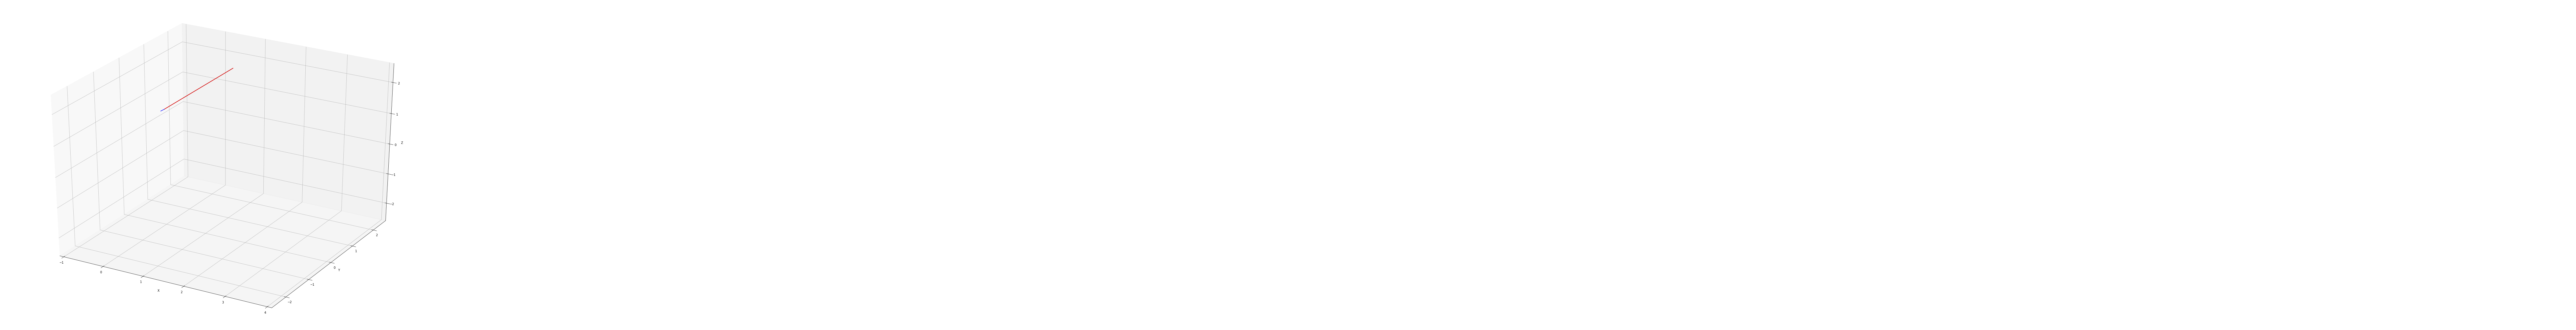

In [60]:
fig = plt.figure(figsize=(20, 15))
fig.patch.set_facecolor('white')
ax = axes3d.Axes3D(fig)
tfct = 3
anim_step = 1

tecoli_center = ecoli_center[0]
tecoli_norm = ecoli_norm[0]
tomega_tang = omega_tang[0]
t0 = omega_tang[0]
t0 = t0 / np.linalg.norm(t0) * np.log10(np.linalg.norm(t0))
tmp_line1 = ax.plot([tecoli_center[0], tecoli_center[0] + t0[0] * tfct], 
                    [tecoli_center[1], tecoli_center[1] + t0[1] * tfct],
                    [tecoli_center[2], tecoli_center[2] + t0[2] * tfct], color='k')[0]
t0 = omega_jeffery[0]
t0 = t0 / np.linalg.norm(t0) * np.log10(np.linalg.norm(t0))
tmp_line2 = ax.plot([tecoli_center[0], tecoli_center[0] + t0[0] * tfct], 
                    [tecoli_center[1], tecoli_center[1] + t0[1] * tfct],
                    [tecoli_center[2], tecoli_center[2] + t0[2] * tfct], color='r')[0]
t0 = det_omega[0]
# t0 = t0 / np.linalg.norm(t0) * np.log10(np.linalg.norm(t0))
tmp_line3 = ax.plot([tecoli_center[0], tecoli_center[0] + t0[0] * tfct], 
                    [tecoli_center[1], tecoli_center[1] + t0[1] * tfct],
                    [tecoli_center[2], tecoli_center[2] + t0[2] * tfct], color='b')[0]
ax.set_xlim3d([-1, 4])
ax.set_xlabel('X')
ax.set_ylim3d([-2.5, 2.5])
ax.set_ylabel('Y')
ax.set_zlim3d([-2.5, 2.5])
ax.set_zlabel('Z')

def update_fun(num, tl1, tl2, tl3, ecoli_center, omega_tang, omega_jeffery, det_omega):
    num = num * anim_step
    # line 1
    t0 = omega_tang[num]
    t0 = t0 / np.linalg.norm(t0) * np.log10(np.linalg.norm(t0))
    t1 = np.vstack([ecoli_center[num], ecoli_center[num] + t0 * tfct])
    tl1.set_data(t1[:, 0], t1[:, 1])
    tl1.set_3d_properties(t1[:, 2])
    # line 2
    t0 = omega_jeffery[num]
    t0 = t0 / np.linalg.norm(t0) * np.log10(np.linalg.norm(t0))
    t2 = np.vstack([ecoli_center[num], ecoli_center[num] + t0 * tfct])
    tl2.set_data(t1[:, 0], t2[:, 1])
    tl2.set_3d_properties(t2[:, 2])
    # line 3
    t0 = det_omega[num]
#     t0 = t0 / np.linalg.norm(t0) * np.log10(np.linalg.norm(t0))
    t3 = np.vstack([ecoli_center[num], ecoli_center[num] + t0 * tfct])
    tl3.set_data(t1[:, 0], t3[:, 1])
    tl3.set_3d_properties(t3[:, 2])
    return tl1, tl2, tl3, 

anim = animation.FuncAnimation(fig, update_fun, len(ecoli_center) // anim_step, interval=50 * anim_step, blit=False, 
                               fargs=(tmp_line1, tmp_line2, tmp_line3, 
                                      ecoli_center, omega_tang, omega_jeffery, det_omega), )
anim
